Pour essayer les exemples présents dans ce tutoriel : 


<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/06_elastic.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/06_elastic.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/NLP/06_elastic.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABcourse/
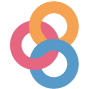

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/NLP/06_elastic.qmd")

Ce chapitre a été écrit avec [Milena Suarez-Castillo](https://milenasuarezcastillo.netlify.app/) 
et présente quelques éléments qui servent de base à un travail en cours
sur les inégalités socioéconomiques dans les
choix de consommation alimentaire.

:warning: Il nécessite une version particulière du package `elasticsearch` pour tenir compte de l'héritage de la version 7 du moteur Elastic. Pour cela, faire

~~~python
pip install elasticsearch==8.2.0
~~~

# Introduction

## Réplication de ce chapitre

Ce chapitre est plus exigeant en termes d'infrastructures que les précédents.
Il nécessite un serveur Elastic. Les utilisateurs du
[SSP Cloud](datalab.sspcloud.fr/) pourront répliquer les exemples de ce cours
car cette technologie est disponible (que ce soit pour indexer une base ou
pour requêter une base existante).

La première partie de ce tutoriel ne nécessite pas d'architecture particulière et
peut ainsi être exécutée en utilisant les packages suivants: 


In [2]:
import time
import pandas as pd

Le script `functions.py`, disponible sur `Github`, regroupe un certain nombre de fonctions utiles. 

{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}

Plusieurs méthodes peuvent être mises en oeuvre pour récupérer
le script d'utilitaires. Voici une proposition

```python
import requests

baseurl = "https://raw.githubusercontent.com/linogaliana/python-datascientist"
branch = "quarto"
path = "content/course/NLP/06_elastic/functions.py"

url = f"{baseurl}/{branch}/{path}"
r = requests.get(url, allow_redirects=True)

open('functions.py', 'wb').write(r.content)
```
{{% /box %}}

Après l'avoir récupéré (cf. encadré dédié), il convient d'importer les fonctions sous forme de module:


In [3]:
import functions as fc

## Cas d'usage


Ce notebook recense et propose d'appréhender quelques outils utilisés
pour le papier présenté aux
[Journées de Méthodologie Statistiques 2022: Galiana and Suarez-Castillo, _"Fuzzy matching on big-data: an illustration with scanner data and crowd-sourced nutritional data"_](http://jms-insee.fr/jms2022s28_2/)
(travail en cours!)


> Combien de calories dans ma recette de cuisine de ce soir? Combien de calories dans mes courses de la semaine?

L'objectif est de reconstituer, à partir de libellés de produits, les caractéristiques nutritionnelles d'une recette.
Le problème est que les libellés des tickets de caisse ne sont pas des champs textuels très propres, ils contiennent, 
par exemple, beaucoup d'abbréviations, toutes n'étant pas évidentes. 

Voici par exemple une série de noms de produits qu'on va utiliser par la suite: 


In [4]:
ticket = ['CROISSANTS X6 400G',
          'MAQUEREAUX MOUTAR.',
          'IGP OC SAUVIGNON B',
          'LAIT 1/2 ECRM UHT',
          '6 OEUFS FRAIS LOCA',
          'ANANAS C2',
          'L POMME FUDJI X6 CAL 75/80 1KG ENV',
          'PLT MIEL',
          'STELLA ARTOIS X6',
          'COTES DU LUBERON AIGUEBRUN 75C']

A ces produits, s'ajoutent les ingrédients suivants, issus de la
[recette du velouté de potiron et carottes de Marmiton](https://www.marmiton.org/recettes/recette_veloute-de-potiron-et-carottes_19009.aspx)
qui sera notre plat principal :


In [5]:
ingredients = ['500 g de carottes',
 '2 pommes de terre',
 "1 gousse d'ail",
 '1/2 l de lait',
 '1/2 l de bouillon de volaille',
 "1 cuillère à soupe de huile d'olive",
 '1 kg de potiron',
 '1 oignon',
 '10 cl de crème liquide (facultatif)']

Essayer de récupérer par webscraping cette liste est un bon exercice pour réviser
les concepts [vus précedemment](#webscraping)


In [6]:
libelles = ticket + ingredients

On part avec cette liste dans notre supermarché virtuel. L'objectif sera de trouver
une méthode permettant passer à l'échelle:
automatiser les traitements, effectuer des recherches efficaces, garder une certaine généralité et flexibilité. 

Ce chapitre montrera par l'exemple l'intérêt d'`Elastic` par rapport à une solution 
qui n'utiliserait que du Python

# Données utilisées


## Les bases offrant des informations nutritionnelles 

Pour un nombre restreint de produits, on pourrait bien-sûr chercher à
la main les caractéristiques des produits en utilisant les 
fonctionalités d'un moteur de recherche:

![](fraise.png)

Cependant, cette approche serait très fastidieuse et 
nécessiterait de récuperer, à la main, chaque caractéristique
pour chaque produit. Ce n'est donc pas envisageable.

Les données disponibles sur Google viennent de l'[USDA](https://fdc.nal.usda.gov/),
l'équivalent américain de notre Ministère de l'Agriculture. 
Cependant, pour des recettes comportant des noms de produits français, ainsi que 
des produits potentiellement transformés, ce n'est pas très pratique d'utiliser
une base de données de produits agricoles en Français. Pour cette raison,
nous proposons d'utiliser les deux bases suivantes, qui servent de base au travail de
Galiana et al. (à venir)


* L'[OpenFoodFacts database](https://fr.openfoodfacts.org/) qui est une base française, 
collaborative de produits alimentaires. Issue d'un projet [Data4Good](https://dataforgood.fr/), il s'agit d'une 
alternative opensource et opendata à la base de données de l'application [Yuka](https://yuka.io/). 
* La table de composition nutritionnelle [Ciqual](https://ciqual.anses.fr) produite par l'Anses. Celle-ci
propose la composition nutritionnelle _moyenne_ des aliments les plus consommés en France. Il s'agit d'une base de données
enrichie par rapport à celle de l'USDA puisqu'elle ne se cantonne pas aux produits agricoles non transformés. 
Avec cette base, il ne s'agit pas de trouver un produit exact mais essayer de trouver un produit type proche du produit
dont on désire connaître les caractéristiques. 

![](openfood.png)

## Import 

Quelques fonctions utiles sont regroupées dans le script `functions.py` et importées dans le notebook. La base OpenFood peut être récupérée en ligne (opération qui peut prendre un peu de temps, on passe ici par le stockage interne de la plateforme en spécifiant `from_latest=False`). La base ciqual, plus légère, est récupérée elle directement en ligne.


In [7]:
openfood = fc.import_openfood()
ciqual = fc.import_ciqual()

/__w/python-datascientist/python-datascientist/content/course/NLP/06_elastic/functions.py:30: DtypeWarning:

Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.



In [8]:
openfood.head()

,product_name,nutriscore_score,energy_100g
8,moutarde au moût de raisin,18.0,936.0
18,Salade de carottes râpées,1.0,134.0
27,Tarte noix de coco,14.0,1594.0
38,Compote de poire,-2.0,657.0
42,Salade de macedoine de légumes,1.0,598.0


In [9]:
ciqual.head()

,alim_nom_fr,"Energie, Règlement UE N° 1169/2011 (kcal/100 g)"
5,"Taboulé ou Salade de couscous, préemballé",179
6,"Salade de pomme de terre à la piémontaise, pré...",130
9,"Crudité, sans assaisonnement (aliment moyen)","29,9"
13,Salade végétale à base de boulgour et/ou quino...,168
16,"Salade de chou ou Coleslaw, avec sauce, préemb...",105


# ElasticSearch ? Mais ce n'est pas du Python ?!

## Qu'est-ce qu'Elastic ? 

ElasticSearch c'est un logiciel qui fournit un moteur de recherche installé sur
un serveur (ou une machine personnelle) qu'il est possible de requêter depuis un client
(une session `Python` par exemple). C'est un moteur de recherche 
très performant, puissant et flexible, extrêmement utilisé dans le domaine de la datascience
sur données textuelles. Un cas d'usage est par exemple de trouver,
dans un corpus de grande dimension
(plusieurs sites web, livres...), un certain texte en s'autorisant des termes voisins
(verbes conjugués, fautes de frappes...).  

Le principe est le même que celui d'un moteur de recherche du web comme Google. 
D'un côté, l'ensemble à parcourir est indexé (c'est-à-dire XXX) pour être en 
mesure de parcourir de manière efficace l'ensemble du corpus.
De l'autre côté, la phase de recherche permet de retrouver l'élément du corpus le
plus cohérent avec la requête de recherche. L'indexation consiste, par exemple,
à pré-définir des traitements des termes du corpus pour gagner en efficacité
lors de la phase de recherche. En effet, l'indexation est une opération peu fréquente
par rapport à la recherche. Pour cette dernière, l'efficacité est cruciale (un site web 
qui prend plusieurs secondes à interpréter une requête simple ne sera pas utilisé). Mais, pour
l'indexation, ceci est moins crucial. 

ElasticSearch propose une interface graphique nommée Kibana. Celle-ci est pratique
pour tester des requêtes et pour superviser le serveur Elastic. Cependant,
pour le passage à l'échelle, notamment pour mettre en lien une base indexée dans
Elastic avec une autre source de données, les API proposées par ElasticSearch
sont beaucoup plus pratiques. Ces API permettent de connecter une session `Python` (idem pour `R`)
à un serveur Elastic afin de communiquer avec lui (échanger des flux via une API REST). 

## ElasticSearch et Python

En `Python`, le package officiel est [`elasticsearch`](https://elasticsearch-py.readthedocs.io/en/v7.12.0/).
Ce dernier permet de configurer les paramètres pour interagir avec un serveur, indexer 
une ou plusieurs bases, envoyer de manière automatisée un ensemble de requêtes
au serveur, récupérer les résultats directement dans une session `Python`...

# Limites de la distance de Levenshtein


On appelle distance de Levenshtein entre deux chaînes de caractères le coût minimal (en nombre d'opérations)
pour transformer la première en la seconde par

* substitution
* insertion
* suppression

La distance de Levenshtein est une mesure très utilisée pour comparer la similarité entre deux
chaînes de caractères. Il existe plusieurs packages pour calculer cette dernière. 
`fuzzywuzzy` est le plus connu mais ce dernier est assez lent (implémentation en pur `Python`).
Le package `rapidfuzz`, présenté ici, propose les mêmes fonctionalités mais est plus rapide car implémenté
en `C++` qui est plus efficace. 


In [10]:
import rapidfuzz # "Rapid fuzzy string matching in Python and C++ using the Levenshtein Distance" soit l'équivalent plus rapide de la librarie fuzzywuzzy
[rapidfuzz.string_metric.levenshtein('salut','slut', weights =(1,1,1)), # Suppression 
 rapidfuzz.string_metric.levenshtein('salut','saalut', weights =(1,1,1)), # Addition 
 rapidfuzz.string_metric.levenshtein('salut','selut', weights =(1,1,1))] # Substitution

[1, 1, 1]

## Produits Ciqual les plus similaires aux produits de la recette

On pourrait écrire une fonction qui prend en argument une liste de libellés d'intérêt et une liste de candidat au *match* et
renvoie le libellé le plus proche. Cependant, le risque est que cet algorithme soit relativement lent s'il n'est pas codé
parfaitement. Il est, à mon avis, plus simple, quand
on est habitué à la logique `pandas`, de faire un produit cartésien pour obtenir un vecteur mettant en miroir
chaque produit de notre recette avec l'ensembles des produits Ciqual et ensuite comparer les deux vecteurs pour prendre,
pour chaque produit, le meilleur *match*. Les bases étant de taille limitée, le produit cartésien n'est pas problématique.
Avec des bases plus conséquentes une stratégie plus parcimonieuse en mémoire devrait être envisagée. 


In [11]:
dist_leven = fc.match_product(libelles, ciqual)

Temps d'exécution total : 0.07 secondes ---


Cette première étape naïve est décevante à plusieurs égards: 

* Certes, on a des matches cohérent (par exemple "Oignon rouge, cru" et "1 oignon")
mais on a plus de couples incohérents ;
* Le temps de calcul peut apparaître faible mais le passage à l'échelle risque d'être compliqué ;
* Les besoins mémoires sont potentiellement importants lors de l'appel à 
`rapidfuzz.process.extract` ce qui peut bloquer le passage à l'échelle
* La distance textuelle n'est pas nécessairement la plus pertinente. 

On a négligé une étape importante: la normalisation (ou nettoyage des textes) présentée dans la 
partie [NLP](#nlp), notamment: 

* harmonisation de la casse, suppression des accents...
* suppressions des mots outils (e.g. ici on va d'abord négliger les quantités pour trouver la nature de l'aliment, en particulier pour Ciqual)
    

## Preprocessing pour améliorer la pertinence des matches

On nettoie les libellés en mobilisant des expressions régulières et un dictionnaire de mots outils.
On peut adapter le nettoyage à la base, par exemple dans ciqual, la cuisson est souvent renseignée et bruite les appariemments.
La fonction `clean_libelle` du script [`utils.py`](#utils.py) propose quelques fonctions
appliquant les méthodes disponibles dans la partie [NLP](#NLP)


In [12]:
from functions import clean_libelle

On peut déjà : 

* Harmoniser la casse et retirer les accents (voir `functions.py`)
* Retirer tout les caractères qui ne sont pas des lettres (chiffres, ponctuations)
* Retirer les caractères isolés


In [13]:
stopWords = ['KG','CL','G','L','CRUE?S?', 'PREEMBALLEE?S?']
replace_regex = {r'[^A-Z]': ' ', r'\b[A-Z0-9]{1,2}?\b':' '} # 

Cela permet d'obtenir les bases nettoyées suivantes:


In [14]:
ciqual = clean_libelle(ciqual, yvar = 'alim_nom_fr', replace_regex = replace_regex, stopWords = stopWords)
ciqual.sample(10)

,alim_nom_fr,"Energie, Règlement UE N° 1169/2011 (kcal/100 g)",libel_clean
1104,Farine de blé tendre ou froment T45 (pour pâti...,356,FARINE BLE TENDRE FROMENT POUR PATISSERIE
1737,"Chinchard, cru",116,CHINCHARD
472,"Chou-fleur, cuit","20,9",CHOU FLEUR CUIT
947,"Pâte d'amande, préemballée",432,PATE AMANDE
2134,Crottin de Chavignol (fromage de chèvre),296,CROTTIN CHAVIGNOL FROMAGE CHEVRE
1089,"Biscuit apéritif, crackers, garni ou fourré, a...",537,BISCUIT APERITIF CRACKERS GARNI FOURRE FROMAGE
2172,Cheddar,399,CHEDDAR
1887,"Anchois au sel (anchoité, semi-conserve)",128,ANCHOIS SEL ANCHOITE SEMI CONSERVE
1744,"Lieu noir, cru","82,5",LIEU NOIR
2503,Rhum,256,RHUM


In [15]:
openfood = clean_libelle(openfood, yvar = 'product_name', replace_regex = replace_regex, stopWords = stopWords)
openfood.sample(10)

,product_name,nutriscore_score,energy_100g,libel_clean
585532,Brioche burger buns,5.0,1075.0,BRIOCHE BURGER BUNS
1725528,Karbonadedeig,-2.0,561.0,KARBONADEDEIG
1732457,Grillost burgare med chili,18.0,1240.0,GRILLOST BURGARE MED CHILI
877103,4 / 4 Haricots Blanc Au Naturel Maingourd*,1.0,397.0,HARICOTS BLANC NATUREL MAINGOURD
1421142,Bio-jogurt,3.0,431.0,BIO JOGURT
1064694,Jambon cuit qualité superieure,11.0,569.0,JAMBON CUIT QUALITE SUPERIEURE
1605870,Gratin dauphinois spar,6.0,397.0,GRATIN DAUPHINOIS SPAR
758673,Salmón ahumado,14.0,954.0,SALMON AHUMADO
1075999,Confiture Fraise Rhubarbe,8.0,1159.0,CONFITURE FRAISE RHUBARBE
1869439,Gallette di riso con cioccolato al latte,22.0,2017.0,GALLETTE RISO CON CIOCCOLATO LATTE


In [16]:
courses = pd.DataFrame(libelles, columns = ['libel'])
courses = clean_libelle(courses, yvar = 'libel', replace_regex = replace_regex, stopWords = stopWords)
courses.sample(10)

,libel,libel_clean
0,CROISSANTS X6 400G,CROISSANTS
10,500 g de carottes,CAROTTES
16,1 kg de potiron,POTIRON
5,ANANAS C2,ANANAS
14,1/2 l de bouillon de volaille,BOUILLON VOLAILLE
2,IGP OC SAUVIGNON B,IGP SAUVIGNON
12,1 gousse d'ail,GOUSSE AIL
17,1 oignon,OIGNON
4,6 OEUFS FRAIS LOCA,OEUFS FRAIS LOCA
15,1 cuillère à soupe de huile d'olive,CUILLERE SOUPE HUILE OLIVE


Les noms de produits sont déjà plus harmonisés. Voyons voir si _a permet de trouver un
*match* dans l'Openfood database: 


In [17]:
dist_leven_openfood = fc.match_product(courses["libel_clean"], openfood, "libel_clean")
dist_leven_openfood.sample(10)

Temps d'exécution total : 14.15 secondes ---


,best_match,distance,index_ciqual,produit
8,STELLA ARTOIS,100.000000,604305,STELLA ARTOIS
3,LAIT UHT ECREME,92.857143,351932,LAIT ECRM UHT
9,COTES AGNEAU GRILLER,65.116279,402326,COTES LUBERON AIGUEBRUN
7,TOP MIEL,75.000000,392935,PLT MIEL
17,OIGNON,100.000000,386166,OIGNON
6,FRUIT CIE POMME,70.588235,461132,POMME FUDJI CAL ENV
2,TOSCANO IGP,66.666667,572506,IGP SAUVIGNON
1,MAQUEREAU MOUTARDE,91.428571,520380,MAQUEREAUX MOUTAR
12,GOUSSE AIL,100.000000,649035,GOUSSE AIL
15,SOUPE PISTOU CUISINEE HUILE OLIVE,77.966102,419703,CUILLERE SOUPE HUILE OLIVE


Pas encore parfait, mais on progresse sur les produits appariés! 
Concernant le temps de calcul, les quelques secondes nécessaires à
ce calcul peuvent apparaître un faible prix à payer. Cependant,
il convient de rappeler que le nombre de produits dans l'ensemble
de recherche est faible. Cette solution n'est donc pas généralisable.



## Réduire les temps de recherche

Finalement, l'idéal serait de disposer d'un **moteur de recherche** adapté à notre besoin, contenant les produits candidats, que l'on pourrait interroger, rapide en lecture, capable de classer les echos renvoyés par pertinence, que l'on pourrait requêter de manière flexible
(par exemple, on pourrait vouloir signaler qu'un echo nous intéresse seulement si la donnée calorique n'est pas manquante).
On pourrait même vouloir qu'il effectue pour nous des prétraitements sur les données. 

C'est exactement ce que fait Elastic

# Indexer une base 

A partir de maintenant, commence, à proprement parler, la démonstration Elastic. Cette 
partie développe les éléments les plus techniques, à savoir l'indexation d'une base. 
Tous les utilisateurs d'Elastic n'ont pas nécessairement à passer par là, ils peuvent 
trouver une base déjà indexée, idéalement par un *data engineer* qui aura optimisé
les traitements. 

Les utilisateurs du [SSP Cloud](https://datalab.sspcloud.fr/accueil), architecture qui
repose sur la technologie [Kubernetes](https://kubernetes.io/) peuvent 
répliquer les éléments de la suite du document. 


## Créer un cluster Elastic sur le DataLab

Pour lancer un service Elastic, il faut cliquer sur [ce lien](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/elastic). 

Une fois créé, vous pouvez explorer l'interface graphique Kibana. Cependant, grâce à l'API Elastic
de Python, on se passera de celle-ci. Donc, en pratique,
une fois lancé, pas besoin d'ouvrir ce service Elastic pour continuer à suivre[^1].

[^1]: Le lancement du service a créé dans votre `NAMESPACE Kubernetes` (l'ensemble de tout vos services) un cluster Elastic.
Vous n'avez droit qu'à un cluster par namespace (ou compte d'utilisateur).
Votre service Jupyter, VSCode, RStudio, etc. est associé au même namespace.
De même qu'il n'est pas nécessaire de comprendre comment fonctionne le moteur d'une voiture pour conduire, 
il n'est pas nécessaire de comprendre la manière dont tout ce beau monde dialogue pour pouvoir utiliser le `SSP Cloud`. 

Dans un terminal, vous pouvez aussi vérifier que vous êtes en mesure de dialoguer avec votre cluster Elastic, qui est prêt à vous écouter:

```shell
kubectl get statefulset
```

Passer par la ligne de commande serait peu commode. 
Nous allons utiliser la librairie `python` `elasticsearch` pour dialoguer avec notre moteur de recherche Elastic.
Les instructions ci-dessous indiquent comment établir la connection.

```python
from elasticsearch import Elasticsearch
HOST = 'elasticsearch-master'

def elastic():
    """Connection avec Elastic sur le data lab"""
    es = Elasticsearch([{'host': HOST, 'port': 9200}], http_compress=True,  timeout=200)
    return es

es = elastic()
```

```
<Elasticsearch([{'host': 'elasticsearch-master', 'port': 9200}])>
```


Maintenant que la connection est établie, deux étapes nous attendent:

1. **Indexation** Envoyer les documents parmi lesquels on veut chercher des echos pertinents dans notre elastic. Un index est une collection de document. Nous pourrions en créer deux: un pour les produits ciqual, un pour les produits openfood
2. **Requête** Chercher les documents les plus pertinents suivant une recherche textuelle flexible. Nous allons rechercher les libellés de notre recette et de notre liste de course.

## Première indexation

On crée donc nos deux index:

~~~python
if not es.indices.exists('openfood'):
    es.indices.create('openfood')
if not es.indices.exists('ciqual'):
    es.indices.create('ciqual')
~~~

Pour l'instant, nos index sont vides! Ils contiennent 0 documents.

~~~python
es.count(index = 'openfood')
~~~

```
{'count': 0, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}
```

Nous allons en rajouter quelques uns ! 

~~~python
es.create(index = 'openfood',  id = 1, body = {'product_name': 'Tarte noix de coco', 'product_name_clean': 'TARTE NOIX COCO'})
es.create(index = 'openfood',  id = 2, body = {'product_name': 'Noix de coco', 'product_name_clean': 'NOIX COCO'})
es.create(index = 'openfood',  id = 3, body = {'product_name': 'Beurre doux', 'product_name_clean': 'BEURRE DOUX'})
~~~

~~~python
es.count(index = 'openfood')
~~~

```
{'count': 3, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}
```

## Première recherche

Faisons notre première recherche: cherchons des noix de pécan! 

~~~python
es.search(index = 'openfood', q = 'noix de pécan')
~~~

```
{'took': 3102, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 2, 'relation': 'eq'}, 'max_score': 0.9400072, 'hits': [{'_index': 'openfood', '_type': '_doc', '_id': '2', '_score': 0.9400072, '_source': {'product_name': 'Noix de coco', 'product_name_clean': 'NOIX COCO'}}, {'_index': 'openfood', '_type': '_doc', '_id': '1', '_score': 0.8272065, '_source': {'product_name': 'Tarte noix de coco', 'product_name_clean': 'TARTE NOIX COCO'}}]}}
```


Intéressons nous aux `hits` (résultats pertinents, ou echos) : nous en avons 2. 
Le score maximal parmi les hits est mentionné dans `max_score` et correspond à celui du deuxième document indexé.

Elastic nous fournit ici un **score de pertinence** dans notre recherche d'information, et classe ainsi les documents renvoyés.

Ici nous utilisons la configuration par défaut. Mais comment est calculé ce score? Demandons à Elastic de nous expliquer le score du document `2` dans la requête `"noix de pécan"`.

~~~python
es.explain(index = 'openfood', id = 2, q = 'noix de pécan')
~~~

```
{'_index': 'openfood', '_type': '_doc', '_id': '2', 'matched': True, 'explanation': {'value': 0.9400072, 'description': 'max of:', 'details': [{'value': 0.49917626, 'description': 'sum of:', 'details': [{'value': 0.49917626, 'description': 'weight(product_name_clean:noix in 1) [PerFieldSimilarity], result of:', 'details': [{'value': 0.49917626, 'description': 'score(freq=1.0), computed as boost * idf * tf from:', 'details': [{'value': 2.2, 'description': 'boost', 'details': []}, {'value': 0.47000363, 'description': 'idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:', 'details': [{'value': 2, 'description': 'n, number of documents containing term', 'details': []}, {'value': 3, 'description': 'N, total number of documents with field', 'details': []}]}, {'value': 0.48275858, 'description': 'tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:', 'details': [{'value': 1.0, 'description': 'freq, occurrences of term within document', 'details': []}, {'value': 1.2, 'description': 'k1, term saturation parameter', 'details': []}, {'value': 0.75, 'description': 'b, length normalization parameter', 'details': []}, {'value': 2.0, 'description': 'dl, length of field', 'details': []}, {'value': 2.3333333, 'description': 'avgdl, average length of field', 'details': []}]}]}]}]}, {'value': 0.9400072, 'description': 'sum of:', 'details': [{'value': 0.4700036, 'description': 'weight(product_name:noix in 1) [PerFieldSimilarity], result of:', 'details': [{'value': 0.4700036, 'description': 'score(freq=1.0), computed as boost * idf * tf from:', 'details': [{'value': 2.2, 'description': 'boost', 'details': []}, {'value': 0.47000363, 'description': 'idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:', 'details': [{'value': 2, 'description': 'n, number of documents containing term', 'details': []}, {'value': 3, 'description': 'N, total number of documents with field', 'details': []}]}, {'value': 0.45454544, 'description': 'tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:', 'details': [{'value': 1.0, 'description': 'freq, occurrences of term within document', 'details': []}, {'value': 1.2, 'description': 'k1, term saturation parameter', 'details': []}, {'value': 0.75, 'description': 'b, length normalization parameter', 'details': []}, {'value': 3.0, 'description': 'dl, length of field', 'details': []}, {'value': 3.0, 'description': 'avgdl, average length of field', 'details': []}]}]}]}, {'value': 0.4700036, 'description': 'weight(product_name:de in 1) [PerFieldSimilarity], result of:', 'details': [{'value': 0.4700036, 'description': 'score(freq=1.0), computed as boost * idf * tf from:', 'details': [{'value': 2.2, 'description': 'boost', 'details': []}, {'value': 0.47000363, 'description': 'idf, computed as log(1 + (N - n + 0.5) / (n + 0.5)) from:', 'details': [{'value': 2, 'description': 'n, number of documents containing term', 'details': []}, {'value': 3, 'description': 'N, total number of documents with field', 'details': []}]}, {'value': 0.45454544, 'description': 'tf, computed as freq / (freq + k1 * (1 - b + b * dl / avgdl)) from:', 'details': [{'value': 1.0, 'description': 'freq, occurrences of term within document', 'details': []}, {'value': 1.2, 'description': 'k1, term saturation parameter', 'details': []}, {'value': 0.75, 'description': 'b, length normalization parameter', 'details': []}, {'value': 3.0, 'description': 'dl, length of field', 'details': []}, {'value': 3.0, 'description': 'avgdl, average length of field', 'details': []}]}]}]}]}]}}
```


Elastic nous explique donc que le score `0.9400072` est le maximum entre deux sous-scores, `0.4991` et `0.9400072`.

Pour chacun de ces sous-scores, le détail de son calcul est donné.
Le premier sous-score n'a accordé un score que par rapport au premier mot (noix), tandis que le second a accordé un score sur la base des deux mots déjà connu dans les documents ("noix" et "de"). Il a ignoré pécan! Jusqu'à présent, ce terme n'est pas connu dans l'index. 

La pertinence d'un mot pour notre recherche est construite sur une variante de la TF-IDF,
considérant qu'un terme est pertinent s'il est souvent présent dans le document (Term Frequency)
alors qu'il est peu fréquent dans les autres document (inverse document frequency).
Ici les notations des documents 1 et 2 sont très proches, la différence est dûe à des IDF plus faibles dans le document 1,
qui est pénalisé pour être légérement plus long. 

Bref, tout ça est un peu lourd, mais assez efficace, en tout cas moins rudimentaire que les distances caractères à caractères pour ramener des echos pertinents.


## Limite de cette première indexation

Pour l'instant, Elastic n'a pas l'air de gérer les fautes de frappes!
Pas le droit à l'erreur dans la requête:

~~~python
es.search(index = 'openfood',q = 'TART NOI')
~~~

```
{'took': 35, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 0, 'relation': 'eq'}, 'max_score': None, 'hits': []}}
```


Cela s'explique par la représentation des champs (*'product_name'* par exemple) qu'Elastic a inféré, puisque nous n'avons rien spécifié.
La représentation d'une variable conditionne la façon dont les champs sont analysés pour calculer la pertinence.
Par exemple, regardons la représentation du champ `product_name`

~~~python
es.indices.get_field_mapping(index = 'openfood', fields = 'product_name')
~~~

```
{'openfood': {'mappings': {'product_name': {'full_name': 'product_name', 'mapping': {'product_name': {'type': 'text'}}}}}}
```

Elastic a compris qu'il s'agissait d'un champ textuel. En revanche, le type est `keyword` n'autorise pas des analyses approximatives donc 
ne permet pas de tenir compte de fautes de frappes.
Pour qu'un echo remonte, un des termes doit matcher exactement. Dommage !
Mais c'est parce qu'on a utilisé le *mapping* par défaut.
En réalité, il est assez simple de préciser un *mapping* plus riche, autorisant une analyse *"fuzzy"* ou *"flou"*.

# Améliorer l'indexation


On peut spécifier la façon dont l'on souhaite analyser le texte.
Par exemple, on peut préciser que l'on souhaite enlever des *stopwords*, raciniser, analyser les termes via des *n-grammes*
pour rendre la recherche plus robuste aux fautes de frappes...

Ces concepts sont présentés dans la partie [NLP](#nlp).
Pour une présentation plus complète, voir
[la documentation officielle d'Elastic](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html)

On propose les analyseurs stockés dans un fichier [schema.json](#schema.json)


Les *n-grammes* sont des séquences de *n* caractères ou plus généralement *n* éléments qui s'enchaînent séquentiellement.
Par exemple, NOI et OIX sont des tri-grammes de caractères dans NOIX. 

Comparer les n-grammes composant des libellés peut permettre d'avoir dans des comparaisons à fautes de frappe/abbréviations près.
Cela fait aussi plus de comparaisons à opérer ! D'où également, l'intérêt d'Elastic, qui intégre facilement et efficacement ces comparaisons. 


On va préciser un peu le schéma de données qu'on souhaite _indexer_, et aussi préciser comment les différents champs seront _analysés_.


### Une indexation plus adaptée

~~~python
import json

if es.indices.exists('openfood'):
    es.indices.delete('openfood')

with open('schema.json') as f:
    mapping = json.load(f)
    
es.indices.create(index = "openfood", body = mapping)    
~~~

Maintenant, les champs textuels *"product_name"* et *"product_name_clean"*
vont pouvoir être analysé aussi via leur n-grammes et après racinisation (et l'un n'exclut pas l'autre!)

~~~python
es.indices.get_field_mapping(index = 'openfood', fields = 'product_name')
~~~

```
{'openfood': {'mappings': {'product_name': {'full_name': 'product_name', 'mapping': {'product_name': {'type': 'text', 'fields': {'keyword': {'type': 'keyword', 'ignore_above': 256}, 'ngr': {'type': 'text', 'analyzer': 'ngram_analyzer'}, 'stem': {'type': 'text', 'analyzer': 'stem_analyzer'}}}}}}}}
```

C'est parti, on envoie toute notre base OpenFood pour pouvoir la requêter ! La fonction suivante (`index_elastic`) va vous faire gagner du temps pour indexer
car indexer chaque produit à la main n'est pas très efficace.

Du coup ça prend quelques minutes ... mais c'est pour nous en faire gagner ensuite. Cette opération est faite une fois, pour préparer des requêtes potentiellement nombreuses!

~~~python
fc.index_elastic(es =es, index_name = "openfood",
        setting_file = 'schema.json',
        df = openfood[['product_name',"libel_clean","energy_100g","nutriscore_score"]].drop_duplicates())
~~~

```
Temps d'exécution total : 263.11 secondes ---
```

~~~python
es.count(index = 'openfood')
~~~

```
{'count': 630727, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}
```


## Nos premières requêtes

Vérifions qu'on recupère quelques tartes aux noix même si l'on fait plein de fautes:

~~~python
es.search(index = 'openfood', q = 'TART NOI', size = 3)
~~~

```
{'took': 4201, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 22.765423, 'hits': [{'_index': 'openfood', '_type': '_doc', '_id': '307496', '_score': 22.765423, '_source': {'product_name': 'Tarte noix', 'libel_clean': 'TARTE NOIX', 'energy_100g': 1833.0, 'nutriscore_score': 23.0}}, {'_index': 'openfood', '_type': '_doc', '_id': '825159', '_score': 22.277456, '_source': {'product_name': 'Tarte aux noix', 'libel_clean': 'TARTE AUX NOIX', 'energy_100g': 4.0, 'nutriscore_score': 4.0}}, {'_index': 'openfood', '_type': '_doc', '_id': '867887', '_score': 22.277456, '_source': {'product_name': 'Tarte aux noix', 'libel_clean': 'TARTE AUX NOIX', 'energy_100g': 1929.0, 'nutriscore_score': 21.0}}]}}
```

Pour automatiser cette approche, on peut définir  la fonctioin suivante

```python
def matchElastic(libelles):
    matches = dict()
    start_time = time.time()
    for l in libelles:
        response = es.search(index = 'openfood', q = l, size = 1)
        if len(response['hits']['hits'])>0:
            matches[l] = response['hits']['hits'][0]['_source']['libel_clean']
    print(80*'-')
    print(f"Temps d'exécution total : {(time.time() - start_time):.2f} secondes ---")
    
    return matches
```

```python
matches = matchElastic(courses['libel_clean'])
pd.DataFrame.from_dict(matches, orient='index')
```

Et voilà, on a un outil très rapide de requête ! 
Maintenant, on peut préciser des requêtes plus sophistiquées![^2]

[^2]: Vous pouvez aussi explorer les possibilités de requêtes via la [doc Elastic](https://www.elastic.co/guide/en/elasticsearch/reference/6.8/query-dsl.html) et vous entrainer à un écrire avec votre index tout neuf.


```python
body = '''
{
  "size": "1",
  "query": {
    "bool": {
      "should": [
        { "match": { "libel_clean":  { "query":  "HUILE OLIVE" , "boost" : 10}}},
        { "match": { "libel_clean.ngr":   "HUILE OLIVE" }}],
      "minimum_should_match": 1,
      "filter": [
      { 
            "range" : {
                "nutriscore_score" : {
                    "gte" : 10,
                    "lte" : 20
                    }
                    }
                    }
      ]
    }
  }
}
'''
```

~~~python
es.search(index = 'openfood', body = body)
~~~

```
{'took': 10322, 'timed_out': False, '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 10000, 'relation': 'gte'}, 'max_score': 174.37657, 'hits': [{'_index': 'openfood', '_type': '_doc', '_id': '693544', '_score': 174.37657, '_source': {'product_name': 'Huile d olive', 'libel_clean': 'HUILE OLIVE', 'energy_100g': 3761.0, 'nutriscore_score': 11.0}}]}}
```


Qu'a-t-on demandé ici? De renvoyer 1 et 1 seul echo (`"size":"1"`) et seulement si celui ci a:
* `"should"`: Au moins un (`"minimum_should_match":"1"`) des termes des deux champs `libel_clean` et `libel_clean.ngr` qui matche sur un terme de _HUILE OLIVE_, l'analyse (la définition du "terme") étant réalisé soit en tant que `text` ("libel_clean") soit en tant que n-gramme `ngr` ("libel_clean.ngr", une analyse que nous avons spécifié dans le mapping) 
* `"filter"`: Le champ `float` nutriscore_score doit être compris entre 10 et 20 ("filter").  

A noter :

1. Les clauses (`"should"`+`"minimum_should_match":"1"`) peuvent être remplacé par un `"must"`, auquel cas, l'echo doit obligatoirement matcher sur chaque clause.
2. Préciser dans `"filter"` (plutôt que dans "`should`") une condition signifie que celle-ci ne participe pas au score de pertinence. 


On n'a pas encore un appariemment très satisfaisant, en particulier sur les boissons. Comment faire ? La réponse sera dans Galiana et al. (à venir)

A vous, de calculer le nombre de calories de notre recette de course ! 